### <span style="color:#50a27f">Построение двинамики движения</span> 

In [10]:
from sympy import *

wx, wy, wz = var("w_x w_y w_z")
q0, qx, qy, qz = var("q_0 q_x q_y q_z")
Jxx, Jyy, Jzz = var("J_{xx} J_{yy} J_{zz}")
Mx, My, Mz = var("M_x M_y M_z")
w = Matrix([wx, wy, wz])
M = Matrix([Mx, My, Mz])
q = Matrix([q0, qx, qy, qz])
J = Matrix([[Jxx, 0, 0],
            [0, Jyy, 0],
            [0, 0, Jzz]])
A = Matrix([[1 - 2*qy**2 - 2*qz**2, 2*qx*qy + 2*qz*q0, 2*qx*qz - 2*qy*q0],
            [2*qx*qy - 2*qz*q0, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz + 2*qx*q0],
            [2*qx*qz + 2*qy*q0, 2*qy*qz - 2*qx*q0, 1 - 2*qx**2 - 2*qy**2]])
A

Matrix([
[-2*q_y**2 - 2*q_z**2 + 1,    2*q_0*q_z + 2*q_x*q_y,   -2*q_0*q_y + 2*q_x*q_z],
[  -2*q_0*q_z + 2*q_x*q_y, -2*q_x**2 - 2*q_z**2 + 1,    2*q_0*q_x + 2*q_y*q_z],
[   2*q_0*q_y + 2*q_x*q_z,   -2*q_0*q_x + 2*q_y*q_z, -2*q_x**2 - 2*q_y**2 + 1]])

In [15]:
w_diff = J.inv() @ (- (w).cross(J @ w) + M)
print(w_diff[0])
print(w_diff[1])
print(w_diff[2])
w_diff

(J_{yy}*w_y*w_z - J_{zz}*w_y*w_z + M_x)/J_{xx}
(-J_{xx}*w_x*w_z + J_{zz}*w_x*w_z + M_y)/J_{yy}
(J_{xx}*w_x*w_y - J_{yy}*w_x*w_y + M_z)/J_{zz}


Matrix([
[ (J_{yy}*w_y*w_z - J_{zz}*w_y*w_z + M_x)/J_{xx}],
[(-J_{xx}*w_x*w_z + J_{zz}*w_x*w_z + M_y)/J_{yy}],
[ (J_{xx}*w_x*w_y - J_{yy}*w_x*w_y + M_z)/J_{zz}]])

### <span style="color:#A254FC">Исследование режимов вращения</span> 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [83]:
Cf = 1
m = 0.03
a = 0.1
b = 0.1

rho =  5.21e-13
S = a*b
M = 5.972e24
G = 6.6743e-11
mu = M * G
v_orb = np.sqrt(mu / 6900e3)
c = Cf * rho * v_orb**2 * S / 6 * m * (a**2 + a*b + b**2)
c

4.514455893826088e-11

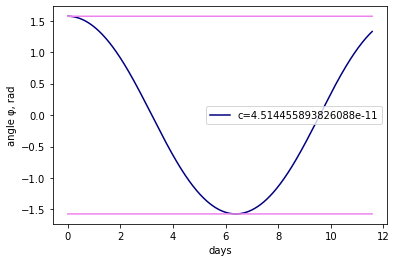

In [91]:
# p = phi
dt = 10.
T = 1e6
days = True

def func(p: float, w: float, c: float, dt: float):
    return p + w * dt, w - dt * c * np.sin(p)

def integrate(c: float, dt: float = 1., T: float = 1000):
    w_list = [0.]
    p_list = [3.1415/2]
    t_list = [0.]
    for i in range(int(round(T / dt))):
        tmp = func(p_list[i], w_list[i], c, dt)
        t_list += [(i+1)*dt]
        p_list += [tmp[0]]
        w_list += [tmp[1]]
    return t_list, p_list

t, p = integrate(c=c, dt=dt, T=T)
t = [i/(3600*24) for i in t] if days else t
plt.plot(t, np.array(p), c='navy', label=f"c={c}")  # /(np.pi/2)
plt.plot(t, [np.pi/2 for _ in range(len(t))], c='violet')
plt.plot(t,[-np.pi/2 for _ in range(len(t))], c='violet')
plt.legend()
plt.xlabel("days" if days else "time t, s")
plt.ylabel("angle φ, rad")
# plt.ylim([-np.pi/2, np.pi/2])
plt.show()

## Аналитика смещённого центра масс

In [1]:
from sympy import *

In [46]:
a, b, ex, ey = var('a b e_x e_y', real=True, constant=True)  # Стороны ЧипСата, отклонения цетра масс
m, f, v = var('m f v', real=True, constant=True)
t = var('t', real=True, constant=False)
n_x = Function("n_x")(t)
n_y = Function("n_y")(t)
n_z = Function("n_z")(t)
w_x = Function("w_x")(t)
w_y = Function("w_y")(t)
w_z = Function("w_z")(t)
x0 = -a + ex
x1 = a + ex
y0 = -b + ey
y1 = b + ey
Ix = m/3 * (x1 - x0) * (y1**3 - y0**3)
Iy = m/3 * (y1 - y0) * (x0**3 - x1**3)
Iz = Ix + Iy  # верно для пластины
eq_n_x = Eq(n_x.diff(t), w_y*n_z - w_z*n_y)
eq_n_y = Eq(n_y.diff(t), w_z*n_x - w_x*n_z)
eq_n_z = Eq(n_z.diff(t), w_x*n_y - w_y*n_x)
eq_x = Eq(f*n_x*v*(x1-x0)*(y1**2-y0**2), Ix * w_x.diff(t) + (Iz - Iy)*w_y*w_z)
eq_y = Eq(f*n_x*v*(y1-y0)*(x0**2-x1**2), Iy * w_y.diff(t) + (Ix - Iz)*w_x*w_z)
eq_z = Eq(0, Iz * w_z.diff(t) + (Iy - Ix)*w_x*w_y)

In [17]:
anw = dsolve({eq_n_x, eq_n_y, eq_n_z, eq_x, eq_y, eq_z})

NotImplementedError: 

## Не решается! Подстановка малого параметра как малый параметр!

In [34]:
print(eq_z)

Eq(0, (-2*a*m*(-(-b + ey)**3 + (b + ey)**3)/3 + 2*b*m*((-a + ex)**3 - (a + ex)**3)/3)*w_x(t)*w_y(t) + (2*a*m*(-(-b + ey)**3 + (b + ey)**3)/3 + 2*b*m*((-a + ex)**3 - (a + ex)**3)/3)*Derivative(w_z(t), t))


In [47]:
tmp = (a + ex)**2
print(f"({tmp.expand()})")

(a**2 + 2*a*e_x + e_x**2)


In [48]:
eq_x_new = Eq(2*a*f*v*(-(b**2 - 2*b*ey) + (b**2 + 2*b*ey))*n_x, 2*a*m*(-(-b**3 + 3*b**2*ey) + (b**3 + 3*b**2*ey))*w_y*w_z/3 + 2*a*m*(-(-b**3 + 3*b**2*ey) + (b**3 + 3*b**2*ey))*Derivative(w_x, t)/3)
eq_y_new = Eq(2*b*f*v*((a**2 - 2*a*ex) - (a**2 + 2*a*ex))*n_x, -2*b*m*((-a**3 + 3*a**2*ex) - (a**3 + 3*a**2*ex))*w_x*w_z/3 + 2*b*m*((-a**3 + 3*a**2*ex) - (a**3 + 3*a**2*ex))*Derivative(w_y, t)/3)
eq_z_new = Eq(0, (-2*a*m*(-(-b**3 + 3*b**2*ey) + (b**3 + 3*b**2*ey))/3 + 2*b*m*((-a**3 + 3*a**2*ex) - (a**3 + 3*a**2*ex))/3)*w_x*w_y + (2*a*m*(-(-b**3 + 3*b**2*ey) + (b**3 + 3*b**2*ey))/3 + 2*b*m*((-a**3 + 3*a**2*ex) - (a**3 + 3*a**2*ex))/3)*Derivative(w_z, t))
eq_x_new

Eq(8*a*b*e_y*f*v*n_x(t), 4*a*b**3*m*w_y(t)*w_z(t)/3 + 4*a*b**3*m*Derivative(w_x(t), t)/3)

In [40]:
anw = dsolve({eq_n_x, eq_n_y, eq_n_z, eq_x_new, eq_y_new, eq_z_new}, [n_x, n_y, n_z, w_x, w_y, w_z])

NotImplementedError: 

In [49]:
eq_n_x

Eq(Derivative(n_x(t), t), -n_y(t)*w_z(t) + n_z(t)*w_y(t))

In [50]:
solve(eq_x_new, w_x.diff(t))[0]

-w_y(t)*w_z(t) + 6*e_y*f*v*n_x(t)/(b**2*m)

In [51]:
solve(eq_y_new, w_y.diff(t))[0]

w_x(t)*w_z(t) + 6*e_x*f*v*n_x(t)/(a**2*m)

In [52]:
solve(eq_z_new, w_z.diff(t))[0]

-(a**2 + b**2)*w_x(t)*w_y(t)/(a**2 - b**2)